In [1]:
import os

data_dir = '../datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

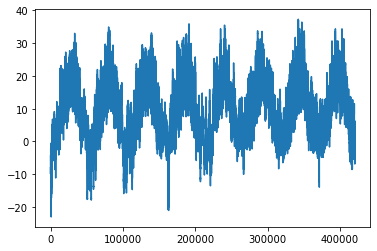

In [3]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

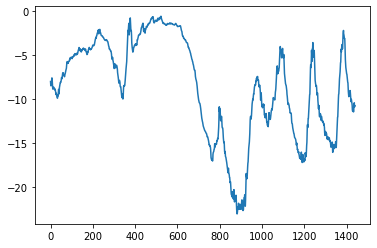

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step, 
                    batch_size=batch_size)
test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None, 
                     step=step, 
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [9]:
evaluate_naive_method()

0.2897359729905486


In [10]:
0.29 * std[1]

2.5672247338393395

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 9s 17ms/step - loss: 1.2514 - val_loss: 0.7280
Epoch 2/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3699 - val_loss: 0.3173
Epoch 3/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2780 - val_loss: 0.3005
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2612 - val_loss: 0.3331
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2529 - val_loss: 0.3345
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2440 - val_loss: 0.3082
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2357 - val_loss: 0.3170
Epoch 8/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2306 - val_loss: 0.3256
Epoch 9/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2249 - val_loss: 0.3224
Epoch 10/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2211 - val_lo

In [12]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

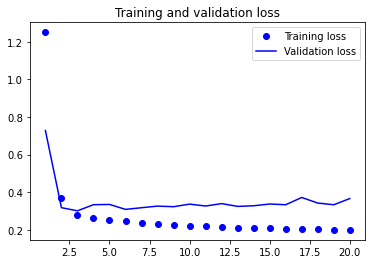

In [13]:
plot_loss(history)

In [14]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 51s 99ms/step - loss: 0.3005 - val_loss: 0.2732
Epoch 2/20
500/500 [==============================] - 49s 99ms/step - loss: 0.2853 - val_loss: 0.2695
Epoch 3/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2821 - val_loss: 0.2641
Epoch 4/20
500/500 [==============================] - 49s 99ms/step - loss: 0.2757 - val_loss: 0.2623
Epoch 5/20
500/500 [==============================] - 50s 99ms/step - loss: 0.2703 - val_loss: 0.2722
Epoch 6/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2659 - val_loss: 0.2668
Epoch 7/20
500/500 [==============================] - 49s 99ms/step - loss: 0.2607 - val_loss: 0.2655
Epoch 8/20
500/500 [==============================] - 49s 99ms/step - loss: 0.2567 - val_loss: 0.2670
Epoch 9/20
500/500 [==============================] - 50s 99ms/step - loss: 0.2535 - val_loss: 0.2651
Epoch 10/20
500/500 [==============================] - 49s 98ms/step - loss: 0.24

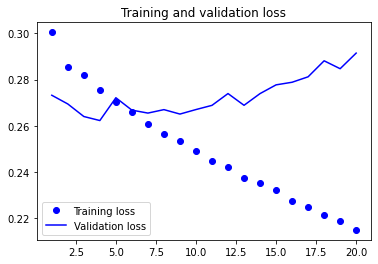

In [15]:
plot_loss(history)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, 
                    steps_per_epoch=500, 
                    epochs=40, 
                    validation_data=val_gen, 
                    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 73s 144ms/step - loss: 0.3343 - val_loss: 0.2812
Epoch 2/40
500/500 [==============================] - 71s 143ms/step - loss: 0.3061 - val_loss: 0.2746
Epoch 3/40
500/500 [==============================] - 72s 144ms/step - loss: 0.3003 - val_loss: 0.2815
Epoch 4/40
500/500 [==============================] - 72s 144ms/step - loss: 0.2943 - val_loss: 0.2753
Epoch 5/40
500/500 [==============================] - 73s 146ms/step - loss: 0.2896 - val_loss: 0.2673
Epoch 6/40
500/500 [==============================] - 71s 143ms/step - loss: 0.2844 - val_loss: 0.2788
Epoch 7/40
500/500 [==============================] - 70s 141ms/step - loss: 0.2816 - val_loss: 0.2714
Epoch 8/40
500/500 [==============================] - 71s 142ms/step - loss: 0.2788 - val_loss: 0.2704
Epoch 9/40
500/500 [==============================] - 71s 142ms/step - loss: 0.2752 - val_loss: 0.2843
Epoch 10/40
500/500 [==============================] - 71s 142ms/step - l

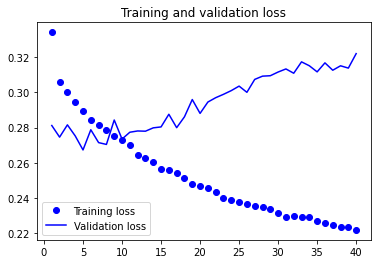

In [17]:
plot_loss(history)